# Clustering using betweenness-based graph algorithms

In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import warnings
import itertools
%run data_cleaning.ipynb

In [ ]:
'''
centroid_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08119_stl_city.csv")
race_data = pd.read_csv(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\weighted_dual_list",delimiter='%',nodetype=str)
nx.draw(stl, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)
'''


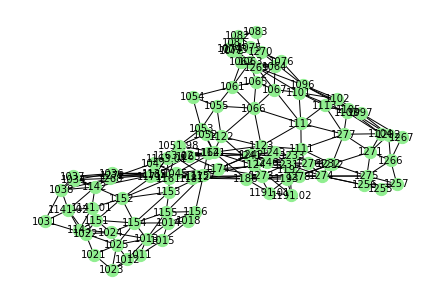

In [2]:
# import data

centroid_locations = pd.read_csv(r"data\CensusTractCentroids.csv")
metro_locations = pd.read_csv(r"data\MetroLinkStations_REGISTERED.csv")
north_south_locations = pd.read_csv(r"data\MetroLinkStations_NS.csv")
census_data = data = pd.read_csv(r"data\B08119_stl_city.csv")
race_data = pd.read_csv(r"data\B08105_stl_city.csv")
stl = nx.read_weighted_edgelist(r"data\weighted_dual_list",delimiter='%')
nx.draw(stl, with_labels=True, node_size=150, node_color='lightgreen', font_size=10)

In [3]:
by_tract = clean(census_data, race_data)
centroid_locations_small = centroid_locations[['NAMELSAD','INTPTLAT','INTPTLON']]
centroid_locations_small = centroid_locations_small.rename(columns = {"NAMELSAD": "location", "INTPTLAT" : "LAT", "INTPTLON" : "LON"})
full_data = by_tract.merge(centroid_locations_small, on='location')
full_data.head()

,location,estimate,transit weight,transit weight (pop),income weight,income weight (pop),race weight,race weight (pop),LAT,LON
0,Census Tract 1011,1039,0.003275,0.434255,0.009653,1.280070,0.007499,0.994323,38.554718,-90.273620
1,Census Tract 1012,1921,0.001162,0.091845,0.009570,0.756349,0.012480,0.986410,38.561824,-90.274863
2,Census Tract 1013,2161,0.003697,0.259777,0.009560,0.671698,0.013909,0.977253,38.566560,-90.264211
3,Census Tract 1014,1502,0.010036,1.014476,0.009614,0.971790,0.010099,1.020846,38.562243,-90.253522
4,Census Tract 1015,1318,0.003381,0.389424,0.009645,1.111024,0.008554,0.985409,38.548544,-90.264511


In [4]:
def mod_max_weighted(graph, k):
    tolerance = 1e-5
    orig = graph.copy()
    to_return = graph.copy()
    q = 0
    q_new = 0
    partition = [orig]
    new_partition = []

    while (len(partition) < k):
        print(f'new partition has length {len(partition)} with elements')
        for i in partition:
            print(i)
        print('--------------------------------------------------------------------------')
        for G in partition:
            # compute modularity matrix B
            G_nodes = list(G.nodes())
            s = np.zeros(len(G_nodes))
            A = nx.to_numpy_array(G, weight='weights')
            degs = list(dict(G.degree()).values())
            B = np.zeros(np.shape(A))
            n = len(G_nodes)
            m = len(G.edges())
            for i in range(n):
                for j in range(n):
                    B[i][j] = A[i][j] - degs[i]*degs[j]/(2*m)
            # find leading eigenvector u of B
            val, vec = np.linalg.eig(B)
            idx = np.argsort(val)[-1]
            largest_vec = vec[:,idx]
            
            # divide nodes into two groups by sign of leading eigenvector
            for i in range(len(largest_vec)):
                if largest_vec[i].real < np.mean(largest_vec):
                    s[i] = -1
                else:
                    s[i] = 1
            
            # create new subgraphs
            n1 = [G_nodes[i] for i in range(n) if s[i] == 1]
            n2 = [G_nodes[i] for i in range(n) if s[i] == -1]
            if len(n1) >= 1:
                new_partition.append(G.subgraph(n1))
            if len(n2) >= 1:
                new_partition.append(G.subgraph(n2))
            
            # update q_new
            q_new = q_new + B.sum()
        
        
        # either stop or re-partition graph
        q_new = q_new / (2*m)
        if abs(q_new - q) > tolerance and q_new < q:
            return partition
        
        else:
            q = q_new
            q_new = 0 
            partition = new_partition
            new_partition = []

    if len(partition) > k: # (this happens if k is odd)
        num_to_combine = len(partition) - k # we need to re-combine this many graphs to get back to k subgraphs
        pairs = [(partition[i], partition[i + 1]) for i in range(0, len(partition), 2)]
        to_test = list(itertools.combinations(pairs, num_to_combine))
        
        # test modularity of all possible combinations to make partition have length k
        best_modularity = 0
        test_idx = 0
        best_test_idx = 0
        for test in to_test:
            partition_copy = partition.copy()
            # remove the pair from the partition and add back in the original before it split into that pair
            for pair in test:
                partition_copy.remove(pair[0])
                partition_copy.remove(pair[1])
                nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
                back_together = orig.subgraph(nodes_to_find)
                partition_copy.append(back_together)
            # re-compute modularity and compare to best modularity
            communities = []
            for clust in partition_copy:
                nodes_in_clust = {n for n in clust.nodes()}
                communities.append(nodes_in_clust)
            modularity = nx.community.modularity(orig, communities)
            if modularity > best_modularity:
                best_modularity = modularity
                best_test_idx = test_idx     
            test_idx = test_idx + 1
        
        # choose the test with the best modularity and combine the pairs in that test for the final result
        final_partition = partition.copy()
        for pair in to_test[best_test_idx]:
            final_partition.remove(pair[0])
            final_partition.remove(pair[1])
            nodes_to_find = list(set(pair[0].nodes()).union(pair[1].nodes()))
            back_together = orig.subgraph(nodes_to_find)
            final_partition.append(back_together)
            
    else: # if k was even
        final_partition = partition

    print(f'ok done. final partition has length {len(final_partition)}')
    value_dict = dict()
    idx = 0
    for sub in final_partition:
        print(sub)
        for n in sub.nodes():
            value_dict[n] = idx
        idx = idx + 1
    nx.set_node_attributes(to_return, value_dict, 'cluster')
    return to_return

new partition has length 1 with elements
Graph with 104 nodes and 285 edges
--------------------------------------------------------------------------
new partition has length 2 with elements
Graph with 47 nodes and 123 edges
Graph with 57 nodes and 149 edges
--------------------------------------------------------------------------
new partition has length 4 with elements
Graph with 22 nodes and 52 edges
Graph with 25 nodes and 58 edges
Graph with 27 nodes and 64 edges
Graph with 30 nodes and 71 edges
--------------------------------------------------------------------------
new partition has length 8 with elements
Graph with 10 nodes and 18 edges
Graph with 12 nodes and 25 edges
Graph with 12 nodes and 22 edges
Graph with 13 nodes and 28 edges
Graph with 12 nodes and 25 edges
Graph with 15 nodes and 30 edges
Graph with 16 nodes and 33 edges
Graph with 14 nodes and 32 edges
--------------------------------------------------------------------------
ok done. final partition has length 1

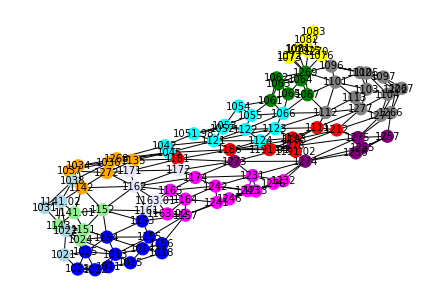

In [5]:
k = 12
test = mod_max_weighted(stl,k)
nx.write_gexf(test, "capstone.gexf")
colors = [test.nodes[node]['cluster'] for node in test.nodes()]
color_dict = {0:'lightgreen', 1:'lightblue', 2:'lavender', 3:'orange', 4:'red', 5:'purple', 6:'yellow', 7:'green', 8:'blue', 9:'magenta', 10:'cyan', 11:'gray'}
new_colors = [color_dict[key] for key in colors]
#print(new_colors)
nx.draw(test, with_labels=True, node_size=150, node_color=new_colors, font_size=10)
plt.show()

## Getting centroid of each community and outputting as a new plan 
(output: point shapefile with all centroids containing a color attribute and a point shapefile comtaining the geomatric mean of each community, a new plan)
install geopandas and fiona to run.

In [9]:
import geopandas as gpd
from shapely.geometry import Point, LineString
from matplotlib.colors import ListedColormap
from shapely.geometry import MultiPoint

#grab output graph info 
centroids_shp = r"data\Centroids.shp"
graph = nx.read_gexf("capstone.gexf")
colors = [graph.nodes[node]['cluster'] for node in test.nodes()]
labels = [graph.nodes[node]['label'] for node in test.nodes()]
gdf = gpd.GeoDataFrame(graph.nodes(data=True), columns=['geometry', 'attributes'])
# Add colors and labels to the GeoDataFrame
gdf['color'] = colors
gdf['NAME'] = labels

#centroids_shp = r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\Centroids.shp"
CentroidsInfo = gpd.read_file(centroids_shp)
# Add color information to centroids GeoDataFrame
centroids_gdf = gdf.merge(CentroidsInfo, on='NAME')
centroids_gdf = gpd.GeoDataFrame(centroids_gdf.rename(columns={'geometry_y': 'geometry'}))
centroids_gdf = centroids_gdf.drop(columns=['geometry_x','attributes'])
centroids_gdf = centroids_gdf.to_crs('EPSG:4326') 
#centroids_gdf['centroid'] = centroids_gdf.groupby('color')['geometry'].transform(lambda x: MultiPoint(x).centroid)


def calculate_centroid(group):
    print(MultiPoint(group.geometry.values).centroid)
    return MultiPoint(group.geometry.values).centroid

cent = centroids_gdf.groupby('color').apply(calculate_centroid)
newPlan = gpd.GeoDataFrame(geometry = cent)
#newPlan['color'] = range(len(newPlan))

centroids_gdf['geometry'] = centroids_gdf['geometry'].apply(lambda x: Point(x))
new_centroids_gdf = gpd.GeoDataFrame(centroids_gdf, geometry='geometry', crs='EPSG:4326')

# Save to file
newPlan.to_file(r"data\newPlanClust.shp", crs="EPSG:4326")
#newPlan_gdf.to_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\newPlanClust.shp",crs="EPSG:4326")
centroids_gdf.to_file(r"data\centroidsColoredByCommunity.shp",crs="EPSG:4326")
#centroids_gdf.to_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\centroidsColoredByCommunity.shp",crs="EPSG:4326")



display(newPlan)

POINT (-90.27608195200624 38.58688570159957)
POINT (-90.30240325312752 38.58483610111618)
POINT (-90.25441111916778 38.60465515908728)
POINT (-90.28960677224143 38.60996501880351)
POINT (-90.24517976339467 38.639232262107676)
POINT (-90.2083719729195 38.629041353728894)
POINT (-90.24036008920223 38.70582369107773)
POINT (-90.26658267064282 38.67507248923384)
POINT (-90.26226722008094 38.564548115588394)
POINT (-90.22678292400172 38.598359394114496)
POINT (-90.28001168863473 38.649649078764604)
POINT (-90.21965240200981 38.66316339908188)


,geometry
color,
0,POINT (-90.27608 38.58689)
1,POINT (-90.30240 38.58484)
2,POINT (-90.25441 38.60466)
3,POINT (-90.28961 38.60997)
4,POINT (-90.24518 38.63923)
5,POINT (-90.20837 38.62904)
6,POINT (-90.24036 38.70582)
7,POINT (-90.26658 38.67507)
8,POINT (-90.26227 38.56455)


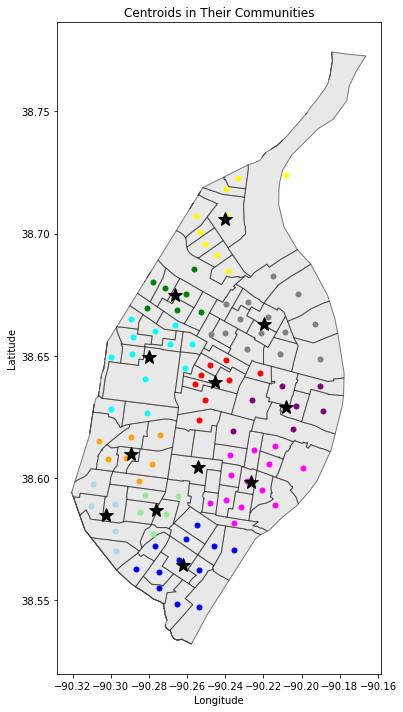

In [10]:
# Read the tracts shapefile
tracts = gpd.read_file(r"data\census tracts\CensusTractsStl.shp")
#tracts = gpd.read_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\census tracts\CensusTractsStl.shp")

# Plotting the graph and tracts polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Plot tracts polygons
tracts.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5)

coloredCentroids = gpd.read_file(r"data\centroidsColoredByCommunity.shp")
#coloredCentroids = gpd.read_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\centroidsColoredByCommunity.shp
color_dict = {0:'lightgreen', 1:'lightblue', 2:'lavender', 3:'orange', 4:'red', 5:'purple', 6:'yellow', 7:'green', 8:'blue', 9:'magenta', 10:'cyan', 11:'gray'}
cmap = ListedColormap([color_dict[i] for i in range(len(color_dict))])

coloredCentroids.head()


#uncomment this if you want prettier colors but uglier code
# Plot centroids from centroidsColoredByCommunity.shp with colormap
for _, row in coloredCentroids.iterrows():
    centroid = row['geometry'].centroid  # Get centroid of the polygon
    color = color_dict[row['color']]
    ax.plot(centroid.x, centroid.y, marker='o', color=color, markersize=5)  # Use colormap for centroids

#uncomment this if you want uglier colors but sinmpler code 
#coloredCentroids.plot(ax=ax, column='color', cmap=cmap, legend=True) 

# Plot centroids of polygons from newPlanClust.shp
newPlan = gpd.read_file(r"data\newPlanClust.shp")
#newPlan = gpd.read_file(r"C:\Users\dodie\Downloads\spring 2024\trio-capstone\data pulling code\data\newPlanClust.shp")
for _, row in newPlan.iterrows():
    centroid = row['geometry'].centroid  # Get centroid of the polygon
    ax.plot(centroid.x, centroid.y, marker='*', color='black', markersize=15)

ax.set_title('Centroids in Their Communities')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.tight_layout()
plt.show()

In [11]:
pd.set_option('display.max_rows',None)

display(coloredCentroids)

,color,NAME,STATEFP,COUNTYFP,TRACTCE,GEOID,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,LAYER,AREA_SQMI,SHAPE_area,SHAPE_len,geometry
0,9,1232,29,510,123200,29510123200,Census Tract 1232,G5020,S,1113329,0,+38.6132904,-090.2137501,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.21375 38.61329)
1,5,1274,29,510,127400,29510127400,Census Tract 1274,G5020,S,3313495,240671,+38.6201595,-090.2060528,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.20461 38.61989)
2,9,1231,29,510,123100,29510123100,Census Tract 1231,G5020,S,1030997,0,+38.6112802,-090.2251869,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.22519 38.61128)
3,9,1276,29,510,127600,29510127600,Census Tract 1276,G5020,S,2970272,814863,+38.6038726,-090.1995009,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.19951 38.60417)
4,9,1233,29,510,123300,29510123300,Census Tract 1233,G5020,S,918025,0,+38.6056360,-090.2169446,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.21694 38.60564)
5,5,1255,29,510,125500,29510125500,Census Tract 1255,G5020,S,1099352,0,+38.6293098,-090.2029461,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.20295 38.62931)
6,5,1278,29,510,127800,29510127800,Census Tract 1278,G5020,S,2546610,0,+38.6319521,-090.2259200,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.22592 38.63195)
7,5,1273,29,510,127300,29510127300,Census Tract 1273,G5020,S,2140388,0,+38.6192983,-090.2357220,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.23572 38.61930)
8,5,1275,29,510,127500,29510127500,Census Tract 1275,G5020,S,1771940,0,+38.6374934,-090.2102717,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.21027 38.63749)
9,5,1256,29,510,125600,29510125600,Census Tract 1256,G5020,S,2078880,491030,+38.6271867,-090.1886661,--CITY_LIMIT_BOUND_2002--,62.11,1.845208e+09,218275.771282,POINT (-90.18857 38.62750)
